In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential, Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


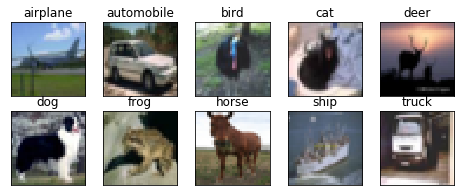

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
    input_img = Input(shape=(32,32,3), name='ImageInput')
  
  # Normal Convolution
    a = Convolution2D(32, (3,3), activation='relu', padding='same', name='Norm_Conv2D_1')(input_img)
    a = BatchNormalization(name='bn1')(a)
    
  # Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))  
    a = Convolution2D(32, (3,1), activation='relu', padding='same', name='Norm_Conv2D_2')(a)
    a = Convolution2D(32, (1,3), activation='relu', padding='same', name='Norm_Conv2D_3')(a)
    a = BatchNormalization(name='bn2')(a)
    a = MaxPooling2D((2,2), name='Maxpool1')(a)
    a = Dropout(0.20)(a)
    
  # Ant Man 1x1 for Bottleneck to reduce total parameters. 
    a = Convolution2D(32, (1, 1), activation='relu', name='BottleNeck_1')(a)
    
  # Grouped Convolution (use 3x3, 5x5 only)  
    b = Convolution2D(16, (3, 3), activation='relu',padding='same',name='Grp_Conv2D_4.1')(a)
    b = BatchNormalization(name='bn3')(b)
    c = Convolution2D(16, (5, 5), activation='relu',padding='same',name='Grp_Conv2D_4.2')(a)
    c = BatchNormalization(name='bn4')(c)
    d = concatenate([b,c])
    d = MaxPooling2D((2,2),name='Maxpool2')(d)
    d = Dropout(0.15)(d)
    
  # Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)   
    e = Convolution2D(32, (3, 3), dilation_rate=(1, 1), activation='relu',padding='same',name='Grp_Dial_Conv2D_5.1')(d)
    e = BatchNormalization(name='bn5')(e)
    f = Convolution2D(32, (3, 3), dilation_rate=(2, 2), activation='relu',padding='same',name='Grp_Dial_Conv2D_5.2')(d)
    f = BatchNormalization(name='bn6')(f)
    g = concatenate([e,f])
    g = MaxPooling2D((2,2),name='Maxpool3')(g)
    g = Dropout(0.10)(g)

  # Depthwise Convolution
    h = DepthwiseConv2D(16, (3,3), activation='relu', padding='same', name='Depth_Conv2D_6')(g)
    h = BatchNormalization(name='bn7')(h)
    h = MaxPooling2D((2,2), name='Maxpool4')(h)
    h = Dropout(0.05)(h)
  
  # Ant Man 1x1 for Bottleneck to reduce total parameters.
    h = Convolution2D(10, (1, 1), activation='relu')(h)  
    
    h = Flatten(name='flatten')(h)
    h= Activation('softmax')(h)
    
    
    model = Model(inputs=input_img, outputs=h)

In [18]:
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Norm_Conv2D_1 (Conv2D)          (None, 32, 32, 32)   896         ImageInput[0][0]                 
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 32, 32, 32)   128         Norm_Conv2D_1[0][0]              
__________________________________________________________________________________________________
Norm_Conv2D_2 (Conv2D)          (None, 32, 32, 32)   3104        bn1[0][0]                        
__________________________________________________________________________________________________
Norm_Conv2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 49s 127ms/step - loss: 1.6155 - acc: 0.4295 - val_loss: 1.3492 - val_acc: 0.5167
Epoch 2/50
390/390 [==============================] - 47s 119ms/step - loss: 1.1924 - acc: 0.5745 - val_loss: 1.3658 - val_acc: 0.5365
Epoch 3/50
390/390 [==============================] - 46s 118ms/step - loss: 1.0296 - acc: 0.6339 - val_loss: 1.1714 - val_acc: 0.5810
Epoch 4/50
390/390 [==============================] - 46s 118ms/step - loss: 0.9381 - acc: 0.6703 - val_loss: 1.1092 - val_acc: 0.6042
Epoch 5/50
390/390 [==============================] - 46s 119ms/step - loss: 0.8699 - acc: 0.6939 - val_loss: 1.0362 - val_acc: 0.6335
Epoch 6/50
390/390 [==============================] - 44s 114ms/step - loss: 0.8258 - acc: 0.7093 - val_loss: 0.8484 - val_acc: 0.7067
Epoch 7/50
390/390 [==============================] - 44s 112ms/step - loss: 0.7824 - acc: 0.7235 - val_loss: 0.7633 - val_acc: 0.7377
Epoch 8/50
390/390 [==============================] - 4

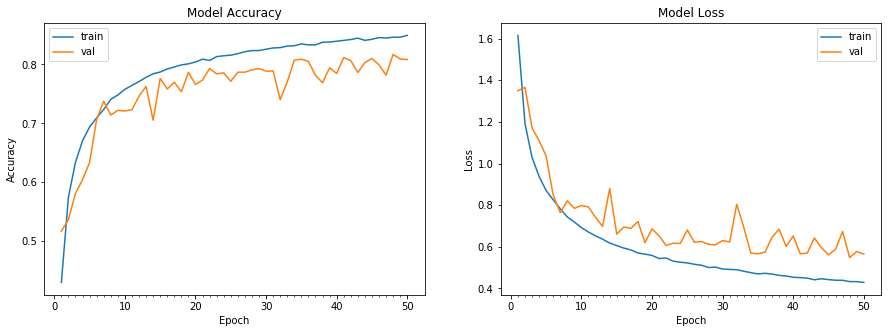

Accuracy on test data is: 80.85


In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))